# Exercise 1

## 1.

In [1]:
import torch
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from typing import TypeVar, List, Optional, Tuple
pyro.set_rng_seed(0)

T = TypeVar('T')


In [2]:
def gibbs_sampler(rho: T, mu1: T, mu2: T, sigma1: T, sigma2: T, warmup: Optional[int] = 100, 

    # initialization 
    data = [[], []]    
    x2 = 10
    x12_mean = mu1 + (rho / (sigma2 ** 2)) * (x2 - mu2)
    x12_variance = sigma1 ** 2 - (rho ** 2) / (sigma1 ** 2)
    x1 = pyro.sample("x1_start", dist.Normal(x12_mean, x12_variance))
    
    # warmup
    for i in range(warmup):
        x21_mean = mu2 + (rho / (sigma1 ** 2)) * (x1 - mu1)
        x21_variance = sigma2 ** 2 - (rho ** 2) / (sigma2 ** 2)
        x2 = pyro.sample("x2_warmup", dist.Normal(x21_mean, x21_variance))
        x12_mean = mu1 + (rho / (sigma2 ** 2)) * (x2 - mu2)
        x12_variance = sigma1 ** 2 - (rho ** 2) / (sigma1 ** 2)
        x1 = pyro.sample("x1_warmup", dist.Normal(x12_mean, x12_variance))
        
    data[0].append(x1)
    data[1].append(x2)

    # actual distributions calulation
    for i in range(iters - warmup):
        x21_mean = mu2 + (rho / (sigma1 ** 2)) * (data[0][i] - mu1)
        x21_variance = sigma2 ** 2 - (rho ** 2) / (sigma2 ** 2)
        data[1].append(pyro.sample("x2", dist.Normal(x21_mean, x21_variance)))
        x12_mean = mu1 + (rho / (sigma2 ** 2)) * (data[1][i] - mu2)
        x12_variance = sigma1 ** 2 - (rho ** 2) / (sigma1 ** 2)
        data[0].append(pyro.sample("x1", dist.Normal(x12_mean, x12_variance)))
        
    return data

## 2.

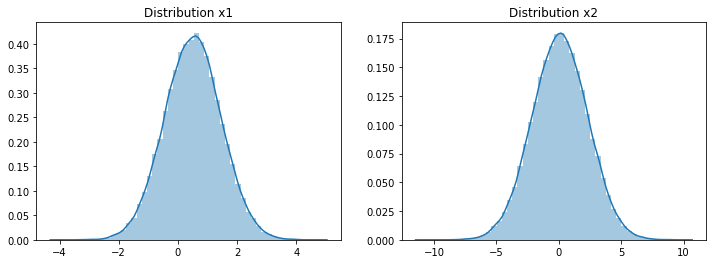

In [5]:
data = gibbs_sampler(0.3, 0.5, 0.1, 1, 1.5, 2000, 100000)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(data[0], ax=axes[0])
sns.distplot(data[1], ax=axes[1])
axes[0].set_title('Distribution x1')
axes[1].set_title('Distribution x2')
plt.show()

## 3.

\begin{align}
\end{align}

From the definition of the conditional distribution
\begin{align}
& f_{Y|X}(y|x)=\frac{f_{X,Y}(x,y)}{f_X(x)}\\
\Rightarrow & f_{X,Y}(x,y)=f_{Y|X}(y|x)f_X(x)
\end{align}
In our case $f_{X_1}(x_1)=\mathcal{N}(\mu_1, \sigma_1) = \frac{1}{\sigma_1\sqrt{2\pi}}e^{-\frac{1}{2}\big(\frac{x_1-\mu_1}{\sigma_1}\big)^2}$ and $$f_{Y|X}(y|x)=f_{X_2|X_1}(x_2|x_1) = \mathcal{N}\Big( \mu_2+\frac{\rho}{\sigma_1^2}(x_1-\mu_1), \sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)=\frac{1}{ \Big( \sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{x_2- \mu_2-\frac{\rho}{\sigma_1^2}(x_1-\mu_1)}{ \sigma_2^2-\frac{\rho^2}{\sigma_1^2}}\Big)^2} $$
So
\begin{align}
 f_{X,Y}(x,y)=  f_{X_1,X_2}(x_1,x_2)&=\frac{1}{ \Big( \sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{x_2- \mu_2-\frac{\rho}{\sigma_1^2}(x_1-\mu_1)}{ \sigma_2^2-\frac{\rho^2}{\sigma_1^2}}\Big)^2} \frac{1}{\sigma_1\sqrt{2\pi}}e^{-\frac{1}{2}\Big(\frac{x_1-\mu_1}{\sigma_1}\Big)^2}\\
  &=\frac{1}{\Big(\frac{\sigma_2^2\sigma_1^2-\rho^2}{\sigma_1}\Big)2\pi}e^{-\frac{1}{2}\big(\frac{x_2- \mu_2-\frac{\rho}{\sigma_1^2}(x_1-\mu_1)}{ \sigma_2^2-\frac{\rho^2}{\sigma_1^2}}\big)^2} e^{-\frac{1}{2}\big(\frac{x_1-\mu_1}{\sigma_1}\big)^2}
\end{align}

Considering only the denominator:
\begin{align}
 &-\frac{1}{2}\big(\frac{x_2- \mu_2-\frac{\rho}{\sigma_1^2}(x_1-\mu_1)}{ \sigma_2^2-\frac{\rho^2}{\sigma_1^2}}\big)^2 -\frac{1}{2}\big(\frac{x_1-\mu_1}{\sigma_1}\big)^2\\
 & -\frac{1}{2}\Big(\Big( \frac{x_2- \mu_2-\frac{\rho}{\sigma_1^2}(x_1-\mu_1)}{ \sigma_2^2-\frac{\rho^2}{\sigma_1^2}}\big)^2 +\big(\frac{x_1-\mu_1}{\sigma_1}\big)^2 \Big)\\
 & -\frac{1}{2} \frac{\Big(x_2- \mu_2-\frac{\rho}{\sigma_1^2}(x_1-\mu_1)\Big)^2\sigma_1^2 + \Big(x_1-\mu_1\Big)^2\Big(\sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)}{\Big(\sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)\sigma_1^2}\\
  & -\frac{1}{2} \frac{(x_2- \mu_2)^2\sigma_1^2 +\frac{\rho^2}{\sigma_1^2}(x_1-\mu_1)^2 -2 \rho(x_1-\mu_1)(x_2- \mu_2) + \Big(x_1-\mu_1\Big)^2\Big(\sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)}{\Big(\sigma_2^2\sigma_1^2-\rho^2\Big)}\\
    & -\frac{1}{2} \frac{(x_2- \mu_2)^2\sigma_1^2 +\frac{\rho^2}{\sigma_1^2}(x_1-\mu_1)^2 -2 \rho(x_1-\mu_1)(x_2- \mu_2) + \Big(x_1-\mu_1\Big)^2\Big(\sigma_2^2-\frac{\rho^2}{\sigma_1^2}\Big)}{\Big(\sigma_2^2\sigma_1^2-\rho^2\Big)}\\
        & -\frac{1}{2} \frac{(x_2- \mu_2)^2\sigma_1^2 +\sigma_2^2(x_1-\mu_1)^2 -2 \rho(x_1-\mu_1)(x_2- \mu_2)}{\Big(\sigma_2^2\sigma_1^2-\rho^2\Big)}\\
\end{align}

So the distribution became:
\begin{align}
f_{X,Y}(x,y)&=\frac{1}{\Big(\frac{\sigma_2^2\sigma_1^2-\rho^2}{\sigma_1}\Big)2\pi}e^{-\frac{1}{2} \frac{(x_2- \mu_2)^2\sigma_1^2 +\sigma_2^2(x_1-\mu_1)^2 -2 \rho(x_1-\mu_1)(x_2- \mu_2)}{(\sigma_2^2\sigma_1^2-\rho^2)}}\\
&= \frac{1}{2\pi\sigma_1\sigma_2\sqrt{1-\rho^2}}e^{-\frac{1}{2(1-\rho^2)}\Big((\frac{x_1-\mu_1}{\sigma_1})^2-2\rho(\frac{x_1-\mu_1}{\sigma_1})(\frac{x_2-\mu_2}{\sigma_2})+(\frac{x_2-\mu_2}{\sigma_2})^2\Big)}\\
\end{align}
Which is a bivariate normal distribution.

# Exercise 2

## 1.

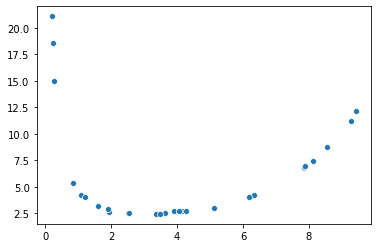

In [13]:
def generate_obs(theta1: T, theta2: T, obs: Optional[int] = 30) -> List:
    
    # initialisation
    data = [[],[]]
    
    # use pyro.sample to create the model
    for i in range(obs):
        rho = pyro.sample("rho", dist.Normal(0, 0.3**2))
        x = pyro.sample("x", dist.Uniform(0, 10)).item()
        data[0].append(x)
        y = (math.e ** (theta1 * x) + theta2)/x + rho
        data[1].append(y)
    
    return data 

#generate the data
data = generate_obs(0.5, 3, 30)

# plot
sns.scatterplot(data[0], data[1])
plt.show()            

## 2.

In [51]:
def noisy_obs(obs: T) -> None:
    
    # create a tensor the the x observations 
    x_obs = torch.tensor(obs[0])
    
    # create a tensor the the y observations 
    y_obs = torch.tensor(obs[1])
    theta1 = pyro.sample("theta1", dist.Exponential(2.))
    theta2 = pyro.sample("theta2", dist.Exponential(0.2))
    gamma = pyro.sample("gamma", dist.Uniform(0,0.5))
    
    # find the y for our model, and put it in a tensor
    y = [(math.e ** (theta1 * obs[0][i]) + theta2)/obs[0][i] for i in range(len(x_obs))] 
    y = torch.tensor(y)
    pyro.sample("y", dist.Normal(y, gamma), obs=y_obs)
    

Warmup:   0%|          | 0/2100 [01:36, ?it/s]


In [49]:
kernel = NUTS(noisy_obs)
mcmc = MCMC(kernel, warmup_steps=2000, num_samples=100, num_chains=1)
mcmc.run(obs=data)

Warmup:   0%|          | 0/2100 [00:00, ?it/s]

TypeError: unsupported operand type(s) for ** or pow(): 'builtin_function_or_method' and 'Tensor'

## 3.


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.55      0.00      0.55      0.54      0.55      2.44      2.94
    theta2      4.78      0.00      4.78      4.78      4.78      6.03      1.15
     gamma      0.48      0.00      0.48      0.48      0.48      3.47      1.87

Number of divergences: 0
dict_keys(['theta1', 'theta2', 'gamma'])


Text(0.5, 1.0, 'Gamma ')

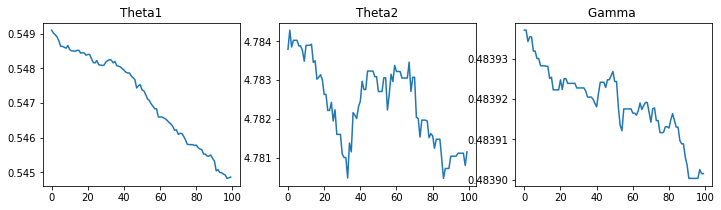

In [44]:
mcmc.summary()
mcmc_samples = mcmc.get_samples(group_by_chain=True)

# create a list of samples for each parameter
chains = []
chains.append(mcmc_samples["theta1"])
chains.append(mcmc_samples["theta2"])
chains.append(mcmc_samples["gamma"])

n_chains, n_samples = chains[0].shape

# plot
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.lineplot(x=range(n_samples), y=chains[0][0], ax=ax[0])
ax[0].set_title("Theta1")
sns.lineplot(x=range(n_samples), y=chains[1][0], ax=ax[1])
ax[1].set_title("Theta2")
sns.lineplot(x=range(n_samples), y=chains[2][0], ax=ax[2])
ax[2].set_title("Gamma ")


From the values of r_hat(above 1) and n_eff we can deduce that, particularly for theta1, the chain has not fully converged. There are no divergences, so the simulated Hamiltonian trajectory didn't departed from the true trajectory. From the sampling we noticed a downward trend for all of the three plots, where only theta2 seems like actually settling around its estimated value.  We can than conclude that theta1 and gamma did not converged.

## 4.

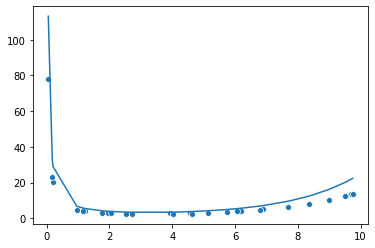

In [11]:
# get a list of the data predicted by our model
new_data = [data[0],[(math.e ** (0.55 * data[0][i]) + 4.78)/data[0][i] for i in range(len(data[0]))]]

# plot the true observasions and our prediction
sns.scatterplot(data[0], data[1])
sns.lineplot(x=new_data[0], y=new_data[1])
plt.show()   